In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.spatial import Voronoi
from tyssue import Epithelium

from tyssue.core.generation import from_2d_voronoi
from tyssue import config
from tyssue.draw.threejs_draw import view_3js
from tyssue import SheetGeometry
from tyssue.core.objects import get_opposite
from tyssue.draw.plt_draw import quick_edge_draw  

from tyssue.draw.threejs_draw import edge_lines
import pythreejs as py3js

import seaborn as sns

import matplotlib as mpl

5113


[None]

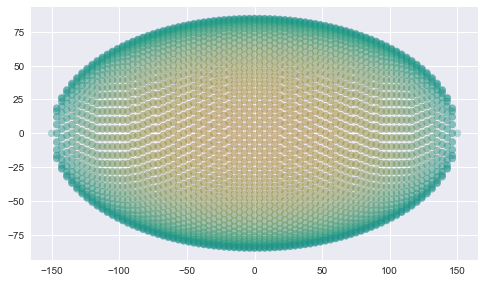

In [3]:
def get_ellipsoid_centers(a, b, c, n_zs,
                          pos_err=0., phase_err=0.):

    dist = c / (1.76*n_zs)
    zs = np.linspace(-c, c, n_zs)

    thetas = np.arcsin(zs/c)
    av_rhos = (a + b) * np.cos(thetas) / 2
    n_cells = np.ceil(av_rhos/dist).astype(np.int)

    phis = np.concatenate(
        [np.linspace(-np.pi, np.pi, nc, endpoint=False)
         + (np.pi/nc) * (i%2) for i, nc in enumerate(n_cells)])
    
    if phase_err > 0:
        phis += np.random.normal(scale=phase_err*np.pi,
                                 size=phis.shape)

    zs = np.concatenate(
        [z * np.ones(nc) for z, nc in zip(zs, n_cells)])
    thetas = np.concatenate(
        [theta * np.ones(nc) for theta, nc in zip(thetas, n_cells)])

    xs = a * np.cos(thetas) * np.cos(phis)
    ys = b * np.cos(thetas) * np.sin(phis)
    
    if pos_err >=0.:
        xs += np.random.normal(scale=pos_err,
                               size=thetas.shape)
        ys += np.random.normal(scale=pos_err,
                               size=thetas.shape)
        zs += np.random.normal(scale=pos_err,
                               size=thetas.shape)
    centers = pd.DataFrame.from_dict(
        {'x': xs, 'y': ys, 'z': zs,
         'theta': thetas, 'phi': phis})
    return centers

centers = get_ellipsoid_centers(85, 85, 150, n_zs=81, phase_err=0)
print(centers.shape[0])
fig, ax = plt.subplots()
ax.scatter(centers.z, centers.x, 
           c=centers.y, cmap='viridis', alpha=0.3)
ax.set(aspect='equal')

In [107]:
from tyssue.io import obj
from tyssue.core.generation import from_3d_voronoi
from tyssue.utils.utils import single_cell
from tyssue.dynamics import BulkModel
from tyssue import BulkGeometry
from tyssue.solvers.sheet_vertex_solver import Solver 

a, b, c = 85, 85, 150

def ellipsoid_sheet(a, b, c, n_zs, **kwargs):

    centers = get_ellipsoid_centers(a, b, c, n_zs,
                                    **kwargs)

    centers['x'] /= a
    centers['y'] /= b
    centers['z'] /= c
    
    centers = centers.append(pd.Series(
        {'x':0, 'y':0, 'z':0,
         'theta':0, 'phi':0,}),
         ignore_index=True)

    vor3d = Voronoi(centers[list('xyz')].values)
    vor3d.close()
    dsets = from_3d_voronoi(vor3d)
    veptm = Epithelium('v', dsets, config.geometry.bulk_spec())
    eptm = single_cell(veptm, centers.shape[0]-1)
    
    eptm.update_specs(config.geometry.bulk_spec())
    eptm.update_specs(config.dynamics.quasistatic_bulk_spec())

    eptm.vert_df['rho'] = np.linalg.norm(eptm.vert_df[eptm.coords], axis=1)
    eptm.vert_df['theta'] = np.arcsin(eptm.vert_df.eval('z/rho'))
    eptm.vert_df['phi'] = np.arctan2(eptm.vert_df['y'], eptm.vert_df['x'])

    eptm.vert_df['x'] = a * np.cos(eptm.vert_df['theta']) * np.cos(eptm.vert_df['phi'])
    eptm.vert_df['y'] = b * np.cos(eptm.vert_df['theta']) * np.sin(eptm.vert_df['phi'])
    eptm.vert_df['z'] = c * np.sin(eptm.vert_df['theta'])

    eptm.cell_df.prefered_vol = (4*np.pi/3) * a * b * c
    eptm.cell_df.prefered_area = 140000

    BulkGeometry.update_all(eptm)
    return eptm

eptm = ellipsoid_sheet(85, 85, 150, 81, phase_err=5e-3)

In [99]:
print(eptm.Nf)

5113


In [108]:
render, scene = view_3js(eptm)

render

In [37]:
from tyssue.io.hdf5 import save_datasets

In [38]:
save_datasets('data/hf5/ellipsoid_sheet_5k.hf5', eptm)

/home/guillaume/miniconda3/envs/tyssue/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: FutureWarning: get_store is deprecated and be removed in a future version
HDFStore(path, **kwargs) is the replacement
  interactivity=interactivity, compiler=compiler, result=result)


In [116]:
def update_height(eptm):
    
    a, b, c = eptm.settings['abc']
    
    eptm.vert_df['rho'] = np.linalg.norm(eptm.vert_df[eptm.coords], axis=1)
    eptm.vert_df['theta'] = np.arcsin(eptm.vert_df['z']/c)
    eptm.vert_df['phi'] = np.arctan2(eptm.vert_df['y'], eptm.vert_df['x'])

    a_b = a - eptm.vert_df['basal_shift']
    b_b = b - eptm.vert_df['basal_shift']
    c_b = c - eptm.vert_df['basal_shift']
    
    eptm.vert_df['xb'] = a_b * np.cos(eptm.vert_df['theta']) * np.cos(eptm.vert_df['phi'])
    eptm.vert_df['yb'] = b_b * np.cos(eptm.vert_df['theta']) * np.sin(eptm.vert_df['phi'])
    eptm.vert_df['zb'] = c_b * np.sin(eptm.vert_df['theta'])
    
    eptm.vert_df['height'] = eptm.vert_df.eval(
        '((x - xb)**2 + (y - yb)**2 + (z - zb)**2)**0.5')
    
    

In [118]:
eptm.update_specs(config.geometry.spherical_sheet(), reset=False)

eptm.update_specs(config.dynamics.quasistatic_sheet_spec(), reset=False)


In [110]:
a, b, c

(85, 85, 150)

In [119]:
eptm.settings['abc'] = a, b, c

In [120]:
update_height(eptm)

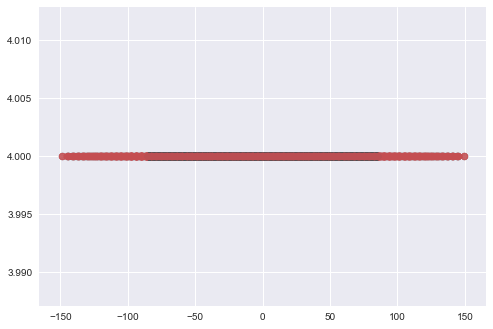

In [121]:
fig, ax = plt.subplots()

ax.scatter(eptm.vert_df.x, eptm.vert_df.height, alpha=0.1)
ax.scatter(eptm.vert_df.y, eptm.vert_df.height, alpha=0.1)
ax.scatter(eptm.vert_df.z, eptm.vert_df.height, alpha=0.1)


In [76]:
def merge_faces(eptm, faces):
    eptm.edge_df['opposite'] = get_opposite(eptm.edge_df)
    edges = pd.concat([eptm.edge_df[eptm.edge_df['face'] == face]
                       for face in faces])
    border = set(edges.index).difference(edges['opposite'])
    inner = set(edges.index).difference(border)

    eptm.edge_df.loc[border, 'face'] = faces[0]
    eptm.edge_df = eptm.edge_df.drop(inner, axis=0)
    eptm.face_df = eptm.face_df.drop(faces[1:], axis=0)
    eptm.vert_df = eptm.vert_df.loc[eptm.edge_df['srce'].unique()]
    

In [29]:
eptm.Nf

7798

In [34]:
Solver.find_energy_min(eptm, BulkGeometry, BulkModel)

      fun: 53199.729725443598
 hess_inv: <19332x19332 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.34352583,  0.2339436 ,  1.67685178, ...,  0.37345463,
       -0.04033939,  0.10396614])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 17
      nit: 14
   status: 0
  success: True
        x: array([  62.08985624,   41.98073496,  -71.00034982, ...,  -18.93945027,
         -8.01193836,  145.63743173])

In [26]:
render, scene = view_3js(eptm)

render

In [14]:
eptm.settings['threshold_length'] = 1e-2


In [13]:
resolve_t1s(eptm, SheetGeometry, SheetModel, Solver, max_iter=60)

NameError: name 'resolve_t1s' is not defined

In [15]:
from tyssue.dynamics import SheetModel as smodel

In [16]:
SheetGeometry.update_all(eptm)

In [17]:
eptm.face_df.area.mean()

17.88583549173066

In [18]:
eptm.vert_df.height.mean()

99.683285008147337

In [19]:
eptm.specs['face']['prefered_area'] = 21
eptm.specs['face']['prefered_height'] = 100


In [21]:
dim_specs = smodel.dimentionalize(eptm.specs)

In [22]:
eptm.face_df['prefered_area'] = dim_specs['face']['prefered_area']
eptm.face_df['prefered_height'] = dim_specs['face']['prefered_height']
eptm.face_df['prefered_vol'] = (dim_specs['face']['prefered_area'] *
                                dim_specs['face']['prefered_height'])
eptm.edge_df['line_tension'] = dim_specs['edge']['line_tension']
eptm.face_df['contractility'] = dim_specs['face']['contractility']


In [28]:
obj.save_junction_mesh('lemon.obj', eptm)

                be advised the file cannot be read back in vispy


In [162]:
%pdb

Automatic pdb calling has been turned OFF


In [25]:
Solver.find_energy_min(eptm, SheetGeometry, smodel)

      fun: 16096332657.449068
 hess_inv: <46776x46776 LbfgsInvHessProduct with dtype=float64>
      jac: array([  -7919.05691956,    3445.16300168,  149005.71524557, ...,
          5449.81387034,   -7943.73419402,    4731.77462497])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1175
      nit: 1169
   status: 0
  success: True
        x: array([  -3.20032609,    1.28994779,  124.88455154, ...,  -60.5273734 ,
        -64.46457232,   22.56400777])

In [11]:
from tyssue.utils import data_at_opposite

def merge_eptms(eptms):
    
    Nes = np.cumsum([eptm.edge_df.index.max()+1
                     for eptm in eptms])
    Nes -= Nes[0]
    Nvs = np.cumsum([eptm.vert_df.index.max()+1
                     for eptm in eptms])
    Nvs -= Nvs[0]
    Nfs = np.cumsum([eptm.face_df.index.max()+1
                     for eptm in eptms])
    Nfs -= Nfs[0]
    for i, eptm in enumerate(eptms):
        eptm.edge_df.index += Nes[i]
        eptm.edge_df.index.name='edge'
        eptm.edge_df[['srce', 'trgt']] += Nvs[i]
        eptm.edge_df['face'] += Nfs[i]
        eptm.vert_df.index += Nvs[i]
        eptm.face_df.index += Nfs[i]
    
    concat_dsets = {key: pd.concat([eptm.datasets[key]
                                    for eptm in eptms])
                    for key in ['edge', 'vert', 'face']}
    
    m_eptm = Epithelium('m', concat_dsets, eptm.specs)
    #cc_eptm = Epithelium('cc', concat_dsets, eptm.specs)
    #cc_eptm.sanitize()
    #cc_eptm.reset_index()

    return m_eptm
        


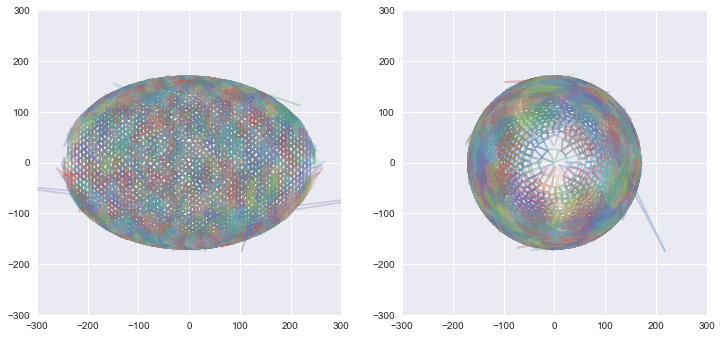

In [167]:
radius = 25
n_cells = centers.shape[0]
n_samples = 600
step = n_cells // n_samples


eptms = [local_voro(centers, radius, face)
         for face in np.arange(0, n_cells, step)]


fig, axes = plt.subplots(1, 2)
for eptm in eptms:
    quick_edge_draw(eptm, ax=axes[0], coords=['z', 'y'], alpha=0.3)
    quick_edge_draw(eptm, ax=axes[1], coords=['x', 'y'], alpha=0.3)

axes[0].set(xlim=(-300, 300),
            ylim=(-300, 300),
            aspect='equal')
axes[1].set(xlim=(-300, 300),
            ylim=(-300, 300),
            aspect='equal')

fig.set_size_inches(12, 8)

In [161]:
def local_voro(centers, radius, face,
               coords=['x', 'y', 'z']):
    
    neighbs = centers[coords].copy()
    for c in coords:
        neighbs[c] -= neighbs.loc[face, c]
    
    rel_dist = np.linalg.norm(neighbs, axis=1)
    
    neighbs = neighbs[rel_dist < 2*radius]
    U, s, V = np.linalg.svd(neighbs.values,
                            full_matrices=False,
                            compute_uv=True)
    rotated = np.dot(neighbs.values, V.T)
    f_ids = neighbs.index
    # voro = Voronoi(rotated[:, [0, 1]])
    dsets = from_2d_voronoi(Voronoi(rotated[:, [0, 1]]))
    dsets['face']['z'] = rotated[:, 2]
    dsets['face']['id'] = f_ids.values
    eptm = Epithelium('loc', dsets, config.geometry.flat_sheet())
    eptm.edge_df['face_z'] = eptm.upcast_face(
        eptm.face_df['z'])
    eptm.edge_df['face_id'] = eptm.upcast_face(
        eptm.face_df['id'])
    eptm.vert_df['z'] = eptm.edge_df.groupby('srce')['face_z'].mean()
    eptm.vert_df[['x', 'y', 'z']] = np.dot(eptm.vert_df[['x', 'y', 'z']].values, V)

    for c in coords:
        eptm.vert_df[c] += centers.loc[face, c]
    eptm.sanitize()
    eptm.reset_index()
    eptm.edge_df['opposite'] = get_opposite(eptm.edge_df)
    eptm.edge_df['opp_face_id'] = data_at_opposite(eptm, eptm.edge_df['face_id'])
    free = eptm.edge_df[eptm.edge_df['opposite']<0].index
    eptm.remove(free)
    eptm.reset_index()
    SheetGeometry.update_all(eptm)
    return eptm
    

In [147]:

left_faces = eptm.face_df[eptm.face_df['z'] < -149].index
right_faces = eptm.face_df[eptm.face_df['z'] > 149].index

merge_faces(eptm, left_faces)
merge_faces(eptm, right_faces)
eptm.reset_index()
eptm.reset_topo()

dbles = eptm.vert_df[eptm.edge_df.groupby('srce').apply(len)==2].index
sts = eptm.edge_df.reset_index().set_index('srce').loc[dbles][['edge', 'trgt']]
tss = eptm.edge_df.reset_index().set_index('trgt').loc[dbles][['edge', 'srce']]

kept_es = sts['edge'].values[::2]
deld_es = sts['edge'].values[1::2]
n_srces = tss['srce'].values[1::2]
n_trgts = sts['trgt'].values[::2]
eptm.edge_df.loc[kept_es, 'srce'] = n_srces
eptm.edge_df.loc[kept_es, 'trgt'] = n_trgts
eptm.edge_df = eptm.edge_df.drop(deld_es, axis=0)

eptm.reset_index()
eptm.reset_topo()


In [169]:
m_eptm = merge_eptms(eptms)



In [170]:
#m_eptm = merge_eptms(eptms)

face_ids = m_eptm.edge_df.groupby('srce')['face_id'].apply(frozenset)
face_ids.index.name = 'vert'
m_eptm.vert_df['face_ids'] = face_ids
m_eptm.vert_df['nf'] = m_eptm.vert_df['face_ids'].apply(len)

m_eptm.edge_df['face'] = m_eptm.edge_df['face_id']
m_eptm.face_df  = m_eptm.face_df.groupby('id').mean()

singles = m_eptm.vert_df.face_ids.drop_duplicates().index
is_in = m_eptm.edge_df.srce.apply(lambda x: x in singles)
#m_eptm.edge_df = m_eptm.edge_df[is_in]

good_vs = (m_eptm.vert_df['nf'] == 3)
#m_eptm.vert_df = m_eptm.vert_df[good_vs]
#m_eptm.edge_df = m_eptm.edge_df[m_eptm.upcast_srce(good_vs)]



In [171]:
uids = m_eptm.vert_df[m_eptm.vert_df['nf']==3].groupby('face_ids').apply(
    lambda df: set(df.index)).reset_index(drop=True)

In [172]:
m_eptm.vert_df['uid'] = np.nan
for new_id, idxs in uids.iteritems():
    m_eptm.vert_df.loc[idxs, 'uid'] = new_id


In [173]:
m_eptm.edge_df['srce'] = m_eptm.upcast_srce(m_eptm.vert_df['uid'])
m_eptm.edge_df['trgt'] = m_eptm.upcast_trgt(m_eptm.vert_df['uid'])
m_eptm.vert_df = m_eptm.vert_df.groupby('uid').mean()
m_eptm.vert_df.index.name = 'vert'
m_eptm.vert_df = m_eptm.vert_df.dropna()
m_eptm.edge_df = m_eptm.edge_df.dropna()
